In [69]:
import json
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow import keras
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import Counter

### Read Data


In [4]:
with open(r'../data/json/closure.json', encoding='utf8', mode='r') as f:
    data = json.load(f)


### Extract Data Feature


In [5]:
CognitiveData_Cold = []
CognitiveData_Hot = []
CognitiveData = []
for i in data.keys():
    temp = list(data[i]['cognitiveData_Cold'].values())
    temp_hot = list(data[i]['cognitiveData_Hot'].values())
    CognitiveData_Cold.append(temp)
    CognitiveData_Hot.append(temp_hot)
    temp.extend(temp_hot)
    CognitiveData.append(temp)
CognitiveData_Cold = np.array(CognitiveData_Cold)
CognitiveData_Hot = np.array(CognitiveData_Hot)
CognitiveData = np.array(CognitiveData)
CognitiveData.shape


(103, 14)

In [6]:
All_data = []
All_keys = []
for i in data.keys():
    temp = []
    for j in data[i].keys():
        try:
            for k in data[i][j].keys():
                if j+"_"+k not in All_keys:
                    All_keys.append(j+"_"+k)
            for x in data[i][j].values():
                temp.append(x)
        except AttributeError:
            temp.append(data[i][j])
            if j not in All_keys:
                    All_keys.append(j)
    All_data.append(temp)
All_data = np.array(All_data)
All_keys = np.array(All_keys)
All_data.shape

(103, 70)

### Model


##### Kmeans

In [88]:
kmeans_CognitiveData_Cold = KMeans(n_clusters=2, random_state=0).fit(CognitiveData_Cold)
kmeans_CognitiveData_Hot = KMeans(n_clusters=2, random_state=0).fit(CognitiveData_Hot)
kmeans_CognitiveData = KMeans(n_clusters=2, random_state=0).fit(CognitiveData)

In [77]:
CognitiveData_Cold[:, 1].shape

(103,)

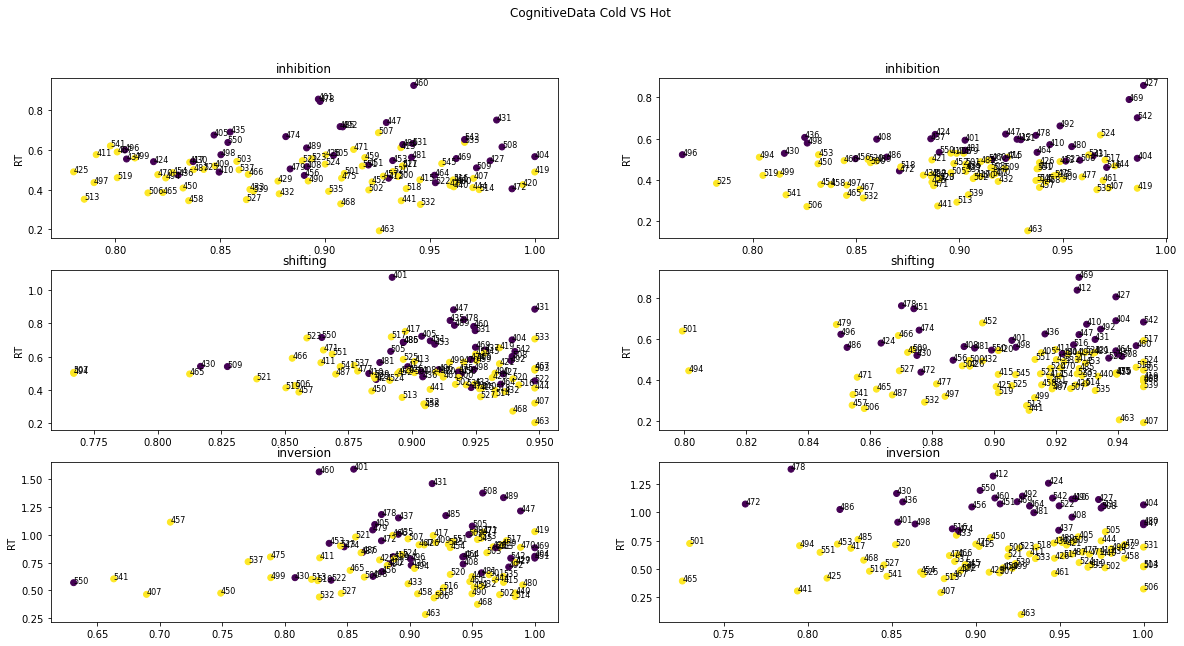

In [89]:
title = ['inhibition', 'shifting', 'inversion']
index = [x for x in data.keys()]
plt.figure(figsize=(20, 10))
plt.suptitle("CognitiveData Cold VS Hot")
for i in range(0, 6, 2):
    plt.subplot(3, 2, i+1)
    plt.title(title[int((i+1)/2)])
    plt.ylabel("RT")
    plt.scatter(CognitiveData_Cold[:, i], CognitiveData_Cold[:,i+1], c = kmeans_CognitiveData_Cold.labels_)
    for j in range(len(index)):
        plt.annotate(index[j], xy = (CognitiveData_Cold[:, i][j],CognitiveData_Cold[:,i+1][j]), size=8 )
    plt.subplot(3, 2, i+2)
    plt.title(title[int((i+1)/2)])
    plt.ylabel("RT")
    plt.scatter(CognitiveData_Hot[:, i], CognitiveData_Hot[:,i+1], c = kmeans_CognitiveData_Hot.labels_)
    for j in range(len(index)):
        plt.annotate(index[j], xy = (CognitiveData_Hot[:, i][j], CognitiveData_Hot[:,i+1][j]), size=8 )


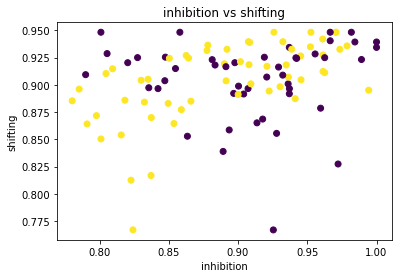

In [50]:
plt.title("inhibition vs shifting")
plt.xlabel("inhibition")
plt.ylabel("shifting")
plt.scatter(CognitiveData_Cold[:, 0], CognitiveData_Cold[:,
            2], c=kmeans_CognitiveData_Cold.labels_)


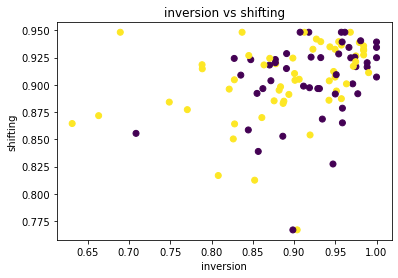

In [51]:
plt.title("inversion vs shifting")
plt.xlabel("inversion")
plt.ylabel("shifting")
plt.scatter(CognitiveData_Cold[:, 4], CognitiveData_Cold[:,2], c=kmeans_CognitiveData_Cold.labels_)


##### Correlation Coefficient Matrix

<AxesSubplot:>

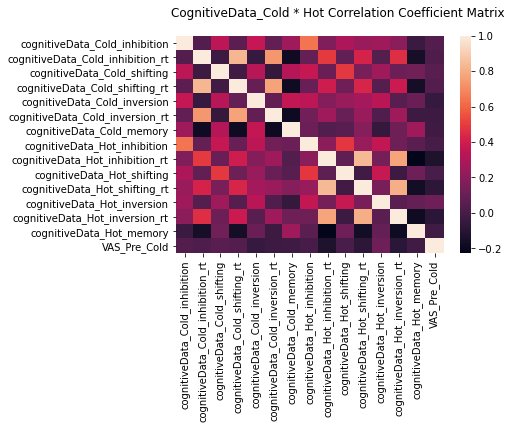

In [120]:
temp = All_data[:,:15]
# label = [x for x in data["401"]['cognitiveData_Cold'].keys()]*2 + ["VAS_Pre_Cold"]
plt.suptitle("CognitiveData_Cold * Hot Correlation Coefficient Matrix")
sns.heatmap(np.corrcoef(temp.T), xticklabels = All_keys[:15], yticklabels = All_keys[:15])

<AxesSubplot:>

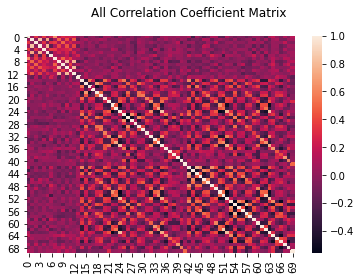

In [121]:
plt.suptitle("All Correlation Coefficient Matrix")
sns.heatmap(np.corrcoef(All_data.T))

<AxesSubplot:>

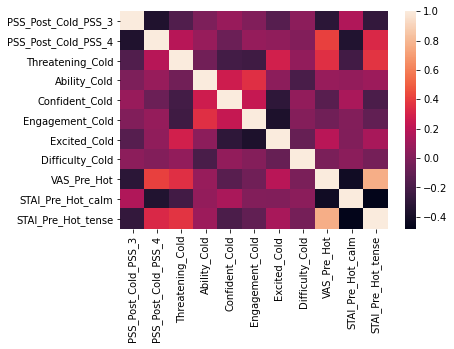

In [118]:
sns.heatmap(np.corrcoef(All_data[:,34:45].T), xticklabels = All_keys[34:45], yticklabels = All_keys[34:45])

##### PIE

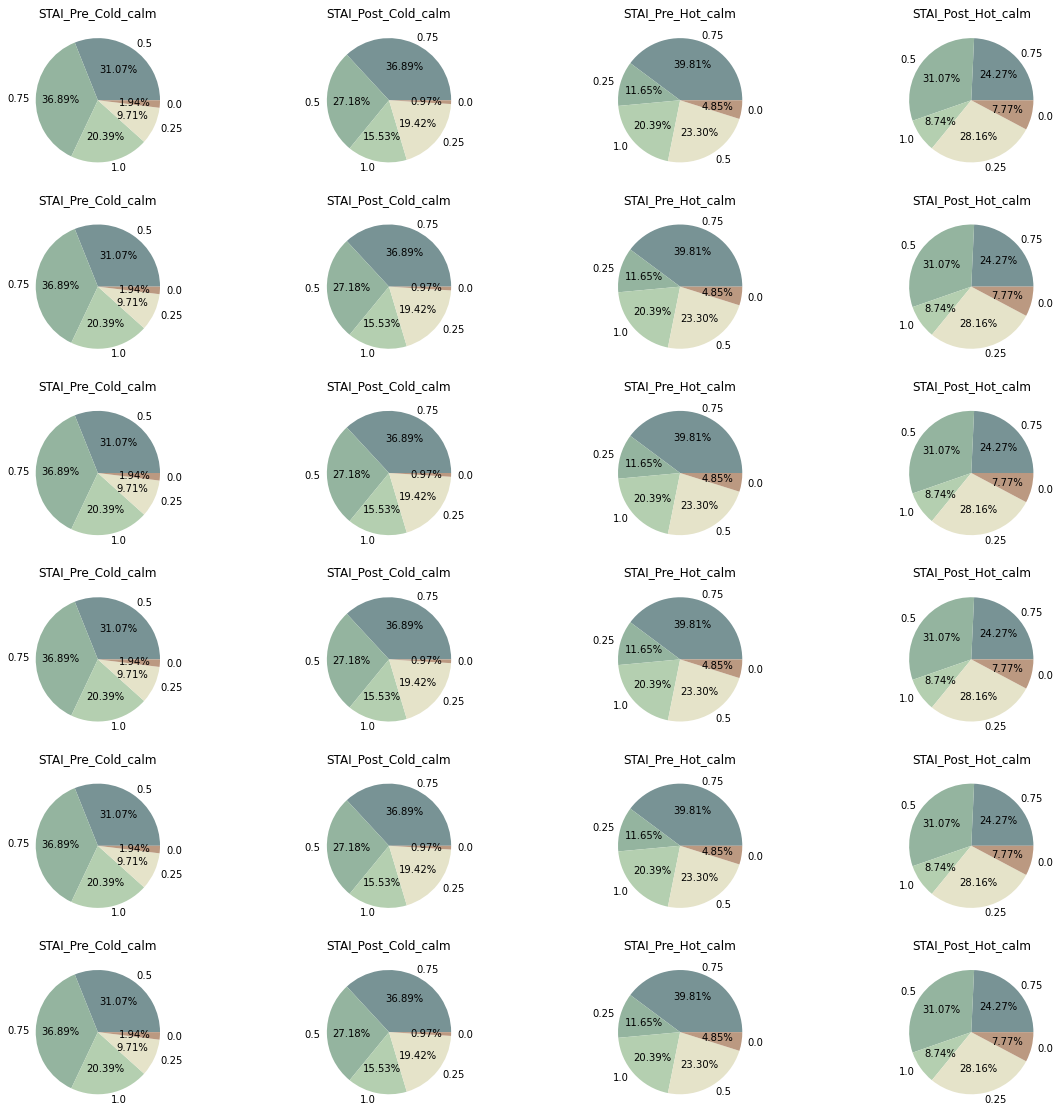

In [161]:
def draw_pie(bias,i,pos,cmap):
    plt.subplot(6,4,i*4+pos)
    plt.title(All_keys[15+bias])
    plt.pie(Counter(All_data[:,15+bias]).values(),
    labels = Counter(All_data[:,15+bias]).keys(),
    autopct='%.2f%%',
    colors = ["#789395","#94B49F","#B4CFB0","#E5E3C9","#BB9981"])

temp_bias = [0, 11, 11+17, 11*2+17]
plt.figure(figsize=(20,20))
cmap = mpl.cm.cool
for i in range(6):
    for j in range(4):
        draw_pie(temp_bias[j],i,j+1,cmap)
plt.show()

##### (memory_cold-memory_hot / [(VAS_post_cold - VAS_pre_cold) - (VAS_post_hot - VAS_pre_hot)])

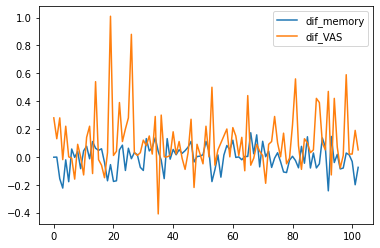

In [178]:
dif_memory = All_data[:,6]-All_data[:,7]
dif_VAS = (All_data[:,14]-All_data[:,14+11]) - (All_data[:,14+11+17]-All_data[:,14+11+17+11])
plt.plot(dif_memory)
plt.plot(dif_VAS)
plt.legend(["dif_memory","dif_VAS"])

Text(0, 0.5, 'dif_VAS')

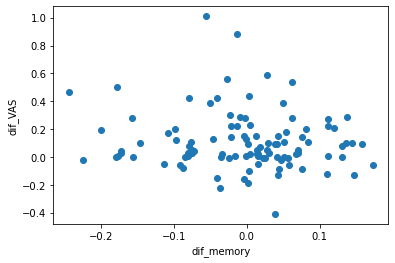

In [182]:
plt.scatter(dif_memory,dif_VAS)
plt.xlabel("dif_memory")
plt.ylabel("dif_VAS")

### ML Methods

##### Construct Data

In [105]:
all_cold_data = All_data[:,0:7]
# all_cold_data = np.hstack((all_cold_data,All_data[:,14:70-28]))
all_hot_data = All_data[:,7:14]
# all_hot_data = np.hstack((all_hot_data,All_data[:,70-28:]))
all_cold_data.shape

(103, 7)

In [106]:
label_hot = np.ones(103)
label_cold = np.zeros(103)
label = np.hstack((label_cold,label_hot))
label_nn = keras.utils.to_categorical(label)
label.shape

(206,)

In [107]:
X = np.vstack((all_cold_data, all_hot_data))
y = np.hstack((label_cold, label_hot))
# X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X,label_nn,shuffle=True)

##### LR

In [36]:
# ALL feature
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_train):
    model_LR = LogisticRegression().fit(X_train[train_index],y_train[train_index])
    print("acc"+str(i)+":",model_LR.score(X_train[test_index],y_train[test_index]))
    i += 1
print("acc_test:",model_LR.score(X_test, y_test))

acc0: 0.5
acc1: 0.375
acc2: 0.5625
acc3: 0.5
acc4: 0.7333333333333333
acc5: 0.4666666666666667
acc6: 0.4666666666666667
acc7: 0.6666666666666666
acc8: 0.7333333333333333
acc9: 0.7333333333333333
acc_test: 0.5769230769230769


In [57]:
# Cognitive
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_train):
    model_LR = LogisticRegression(penalty="l2").fit(X_train[train_index],y_train[train_index])
    print("acc"+str(i)+":",model_LR.score(X_train[test_index],y_train[test_index]))
    i += 1
print("acc_test:",model_LR.score(X_test, y_test))

acc0: 0.75
acc1: 0.5
acc2: 0.5625
acc3: 0.625
acc4: 0.3333333333333333
acc5: 0.4666666666666667
acc6: 0.5333333333333333
acc7: 0.6666666666666666
acc8: 0.5333333333333333
acc9: 0.4666666666666667
acc_test: 0.6346153846153846


##### SVC

In [67]:
# ALL feature
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_train):
    model_SVM = SVC(kernel="linear").fit(X_train[train_index],y_train[train_index])
    print("acc"+str(i)+":",model_SVM.score(X_train[test_index],y_train[test_index]))
    i += 1
print("acc_test:",model_SVM.score(X_test, y_test))

acc0: 0.625
acc1: 0.3125
acc2: 0.625
acc3: 0.6875
acc4: 0.4666666666666667
acc5: 0.6
acc6: 0.4666666666666667
acc7: 0.3333333333333333
acc8: 0.6666666666666666
acc9: 0.5333333333333333
acc_test: 0.5576923076923077


In [63]:
# Cognitive
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_train):
    model_SVM = SVC(kernel="rbf").fit(X_train[train_index],y_train[train_index])
    print("acc"+str(i)+":",model_SVM.score(X_train[test_index],y_train[test_index]))
    i += 1
print("acc_test:",model_SVM.score(X_test, y_test))

acc0: 0.8125
acc1: 0.5
acc2: 0.5625
acc3: 0.4375
acc4: 0.4
acc5: 0.4
acc6: 0.6
acc7: 0.6
acc8: 0.4666666666666667
acc9: 0.4666666666666667
acc_test: 0.6923076923076923


##### DNN

Train on 154 samples, validate on 52 samples
Epoch 1/100
154/154 [==============================] - 0s 2ms/step - loss: 0.6942 - acc: 0.5325 - val_loss: 0.6821 - val_acc: 0.5769
Epoch 2/100
154/154 [==============================] - 0s 278us/step - loss: 0.6911 - acc: 0.5519 - val_loss: 0.6861 - val_acc: 0.6346
Epoch 3/100
154/154 [==============================] - 0s 291us/step - loss: 0.6892 - acc: 0.5325 - val_loss: 0.6883 - val_acc: 0.5769
Epoch 4/100
154/154 [==============================] - 0s 421us/step - loss: 0.6880 - acc: 0.5325 - val_loss: 0.6895 - val_acc: 0.5385
Epoch 5/100
154/154 [==============================] - 0s 356us/step - loss: 0.6865 - acc: 0.5584 - val_loss: 0.6896 - val_acc: 0.5385
Epoch 6/100
154/154 [==============================] - 0s 432us/step - loss: 0.6855 - acc: 0.5779 - val_loss: 0.6910 - val_acc: 0.5192
Epoch 7/100
154/154 [==============================] - 0s 365us/step - loss: 0.6842 - acc: 0.5779 - val_loss: 0.6920 - val_acc: 0.5000
Epoch 8/100


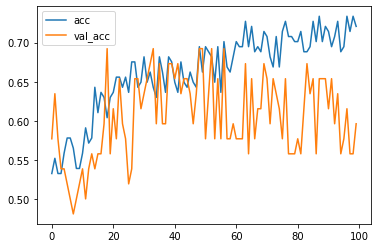

In [84]:
# ALL_data
model = Sequential()
model.add(Dense(32,activation="relu"))
model.add(Dense(2,activation="sigmoid"))

model.compile(loss = keras.losses.categorical_crossentropy,
                optimizer='sgd',
                metrics=["accuracy"])

history = model.fit(X_train,y_train,batch_size=3,epochs=100,verbose=1,validation_data=(X_test,y_test))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.show()

Train on 154 samples, validate on 52 samples
Epoch 1/100
154/154 [==============================] - 1s 4ms/step - loss: 0.7110 - acc: 0.4935 - val_loss: 0.6954 - val_acc: 0.5192
Epoch 2/100
154/154 [==============================] - 0s 298us/step - loss: 0.6987 - acc: 0.4935 - val_loss: 0.6918 - val_acc: 0.5192
Epoch 3/100
154/154 [==============================] - 0s 324us/step - loss: 0.6938 - acc: 0.4935 - val_loss: 0.6906 - val_acc: 0.5000
Epoch 4/100
154/154 [==============================] - 0s 363us/step - loss: 0.6915 - acc: 0.5000 - val_loss: 0.6902 - val_acc: 0.5000
Epoch 5/100
154/154 [==============================] - 0s 330us/step - loss: 0.6902 - acc: 0.5195 - val_loss: 0.6901 - val_acc: 0.5000
Epoch 6/100
154/154 [==============================] - 0s 426us/step - loss: 0.6893 - acc: 0.5584 - val_loss: 0.6902 - val_acc: 0.5385
Epoch 7/100
154/154 [==============================] - 0s 356us/step - loss: 0.6878 - acc: 0.6234 - val_loss: 0.6902 - val_acc: 0.5385
Epoch 8/100


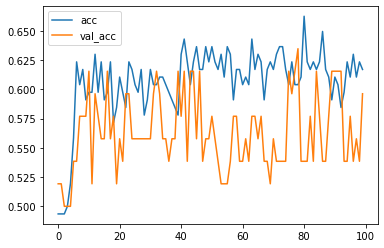

In [108]:
# Cognitive
model = Sequential()
model.add(Dense(32,activation="relu"))
model.add(Dense(2,activation="sigmoid"))

model.compile(loss = keras.losses.categorical_crossentropy,
                optimizer='sgd',
                metrics=["accuracy"])

history = model.fit(X_train,y_train,batch_size=3,epochs=100,verbose=1,validation_data=(X_test,y_test))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.show()